In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
import func_get
import func_signal
import func_backtest

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/read.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'cross'

In [7]:
start_date = dt.datetime(2022, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '15m',
    'target_side': ['buy'],
    'base': {
        'symbol': ['BTC-PERP'],
        'open': {
            '15m': {
                'cross_sma': {
                    'check': ['check_signal_side_change'],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        },
        'close': {
            '15m': {
                'cross_sma': {
                    'check': ['check_signal_side'],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 10,
    'leverage': 10,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = func_get.get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/186
base: timeframe 1/1 symbol 1/1 date 2/186
base: timeframe 1/1 symbol 1/1 date 3/186
base: timeframe 1/1 symbol 1/1 date 4/186
base: timeframe 1/1 symbol 1/1 date 5/186
base: timeframe 1/1 symbol 1/1 date 6/186
base: timeframe 1/1 symbol 1/1 date 7/186
base: timeframe 1/1 symbol 1/1 date 8/186
base: timeframe 1/1 symbol 1/1 date 9/186
base: timeframe 1/1 symbol 1/1 date 10/186
base: timeframe 1/1 symbol 1/1 date 11/186
base: timeframe 1/1 symbol 1/1 date 12/186
base: timeframe 1/1 symbol 1/1 date 13/186
base: timeframe 1/1 symbol 1/1 date 14/186
base: timeframe 1/1 symbol 1/1 date 15/186
base: timeframe 1/1 symbol 1/1 date 16/186
base: timeframe 1/1 symbol 1/1 date 17/186
base: timeframe 1/1 symbol 1/1 date 18/186
base: timeframe 1/1 symbol 1/1 date 19/186
base: timeframe 1/1 symbol 1/1 date 20/186
base: timeframe 1/1 symbol 1/1 date 21/186
base: timeframe 1/1 symbol 1/1 date 22/186
base: timeframe 1/1 symbol 1/1 date 23/186
base: timeframe 1/1 

### Add signal

In [10]:
ohlcv_df_dict = func_signal.add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add cross_sma to BTC-PERP 15m
base add cross_sma to BTC-PERP 15m


### Back test

In [11]:
action_time_list = func_get.gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = func_backtest.get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = func_backtest.close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = func_backtest.open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = func_backtest.update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2022-01-01 00:15:00: progress 1/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:30:00: progress 2/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:45:00: progress 3/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:00:00: progress 4/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:15:00: progress 5/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:30:00: progress 6/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:45:00: progress 7/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 02:00:00: progress

     base BTC-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.002048212261811804
     price: 47259.0
     tp: inf
     sl: 0
Time 2022-01-03 20:30:00: progress 274/16804
  BTC-PERP
       side: buy
       price: 47259.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 20:45:00: progress 275/16804
  BTC-PERP
       side: buy
       price: 47235.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 21:00:00: progress 276/16804
  BTC-PERP
       side: buy
       price: 47137.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 21:15:00: progress 277/16804
  BTC-PERP
       side: buy
       price: 46955.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-03 21:30:00: progress 278/16804
  BTC-PERP
  

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 07:15:00: progress 509/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 07:30:00: progress 510/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 07:45:00: progress 511/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 08:00:00: progress 512/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 08:15:00: progress 513/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 08:30:00: progress 514/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 08:45:00: progress 515/16804
  BTC-PERP
     base BTC-PERP c

       side: buy
       price: 41812.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-09 12:45:00: progress 819/16804
  BTC-PERP
       side: buy
       price: 41821.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-09 13:00:00: progress 820/16804
  BTC-PERP
       side: buy
       price: 41723.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-09 13:15:00: progress 821/16804
  BTC-PERP
       side: buy
       price: 41701.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-09 13:30:00: progress 822/16804
  BTC-PERP
       side: buy
       price: 41735.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-09 13:45:00: progress 823/16804
  BTC-

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-11 14:30:00: progress 1018/16804
  BTC-PERP
       side: buy
       price: 42161.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-11 14:45:00: progress 1019/16804
  BTC-PERP
       side: buy
       price: 42111.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-11 15:00:00: progress 1020/16804
  BTC-PERP
       side: buy
       price: 42095.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-11 15:15:00: progress 1021/16804
  BTC-PERP
       side: buy
       price: 42195.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-11 15:30:00: progress 1022/16804
  BTC-PERP
       side: buy
       price: 42221.0
       sl: 0
       sl_fl

       side: buy
       price: 43585.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 12:45:00: progress 1203/16804
  BTC-PERP
       side: buy
       price: 43650.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 13:00:00: progress 1204/16804
  BTC-PERP
       side: buy
       price: 43650.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 13:15:00: progress 1205/16804
  BTC-PERP
       side: buy
       price: 43651.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 13:30:00: progress 1206/16804
  BTC-PERP
       side: buy
       price: 43733.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-13 13:45:00: progress 1207/16804
 

       side: buy
       price: 42899.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 22:00:00: progress 1432/16804
  BTC-PERP
       side: buy
       price: 43086.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 22:15:00: progress 1433/16804
  BTC-PERP
       side: buy
       price: 43140.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 22:30:00: progress 1434/16804
  BTC-PERP
       side: buy
       price: 43090.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 22:45:00: progress 1435/16804
  BTC-PERP
       side: buy
       price: 43166.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 23:00:00: progress 1436/16804
 

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 23:45:00: progress 1631/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 00:00:00: progress 1632/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 00:15:00: progress 1633/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 00:30:00: progress 1634/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 00:45:00: progress 1635/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 01:00:00: progress 1636/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-18 01:15:00: progress 1637/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-20 22:15:00: progress 1913/16804
  BTC-PERP
       side: buy
       price: 42974.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-20 22:30:00: progress 1914/16804
  BTC-PERP
       side: buy
       price: 43084.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-20 22:45:00: progress 1915/16804
  BTC-PERP
       side: buy
       price: 43180.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-20 23:00:00: progress 1916/16804
  BTC-PERP
       side: buy
       price: 43163.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-20 23:15:00: progress 1917/16804
  BTC-PERP
       side: buy
       price: 43205.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 07:45:00: progress 2143/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 08:00:00: progress 2144/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 08:15:00: progress 2145/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 08:30:00: progress 2146/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 08:45:00: progress 2147/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 09:00:00: progress 2148/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 09:15:00: progress 2149/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 19:15:00: progress 2381/16804
  BTC-PERP
       side: buy
       price: 36266.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 19:30:00: progress 2382/16804
  BTC-PERP
       side: buy
       price: 36214.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 19:45:00: progress 2383/16804
  BTC-PERP
       side: buy
       price: 36422.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 20:00:00: progress 2384/16804
  BTC-PERP
       side: buy
       price: 36517.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-25 20:15:00: progress 2385/16804
  BTC-PERP
       side: buy
       price: 36355.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 13:15:00: progress 2549/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 13:30:00: progress 2550/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 13:45:00: progress 2551/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 14:00:00: progress 2552/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 14:15:00: progress 2553/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 14:30:00: progress 2554/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-27 14:45:00: progress 2555/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 19:15:00: progress 2765/16804
  BTC-PERP
       side: buy
       price: 37643.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 19:30:00: progress 2766/16804
  BTC-PERP
       side: buy
       price: 37651.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 19:45:00: progress 2767/16804
  BTC-PERP
       side: buy
       price: 37815.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 20:00:00: progress 2768/16804
  BTC-PERP
       side: buy
       price: 37804.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-29 20:15:00: progress 2769/16804
  BTC-PERP
       side: buy
       price: 37794.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 16:00:00: progress 2944/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 16:15:00: progress 2945/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 16:30:00: progress 2946/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 16:45:00: progress 2947/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 17:00:00: progress 2948/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 17:15:00: progress 2949/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 17:30:00: progress 2950/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 11:00:00: progress 3116/16804
  BTC-PERP
       side: buy
       price: 38572.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 11:15:00: progress 3117/16804
  BTC-PERP
       side: buy
       price: 38427.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 11:30:00: progress 3118/16804
  BTC-PERP
       side: buy
       price: 38437.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 11:45:00: progress 3119/16804
  BTC-PERP
       side: buy
       price: 38430.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 12:00:00: progress 3120/16804
  BTC-PERP
       side: buy
       price: 38425.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:15:00: progress 3361/16804
  BTC-PERP
       side: buy
       price: 40200.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:30:00: progress 3362/16804
  BTC-PERP
       side: buy
       price: 40204.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 00:45:00: progress 3363/16804
  BTC-PERP
       side: buy
       price: 40272.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 01:00:00: progress 3364/16804
  BTC-PERP
       side: buy
       price: 40372.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 01:15:00: progress 3365/16804
  BTC-PERP
       side: buy
       price: 40375.0
       sl: 0
       sl_fl

       side: buy
       price: 41617.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 16:30:00: progress 3522/16804
  BTC-PERP
       side: buy
       price: 41607.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 16:45:00: progress 3523/16804
  BTC-PERP
       side: buy
       price: 41604.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 17:00:00: progress 3524/16804
  BTC-PERP
       side: buy
       price: 41604.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 17:15:00: progress 3525/16804
  BTC-PERP
       side: buy
       price: 41636.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-06 17:30:00: progress 3526/16804
 

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 12:00:00: progress 3696/16804
  BTC-PERP
       side: buy
       price: 44236.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 12:15:00: progress 3697/16804
  BTC-PERP
       side: buy
       price: 44317.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 12:30:00: progress 3698/16804
  BTC-PERP
       side: buy
       price: 44268.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 12:45:00: progress 3699/16804
  BTC-PERP
       side: buy
       price: 44307.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-08 13:00:00: progress 3700/16804
  BTC-PERP
       side: buy
       price: 44470.0
       sl: 0
       sl_fl

       side: buy
       price: 44509.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 06:30:00: progress 3866/16804
  BTC-PERP
       side: buy
       price: 44356.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 06:45:00: progress 3867/16804
  BTC-PERP
       side: buy
       price: 44312.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 07:00:00: progress 3868/16804
  BTC-PERP
       side: buy
       price: 44277.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 07:15:00: progress 3869/16804
  BTC-PERP
       side: buy
       price: 44179.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-10 07:30:00: progress 3870/16804
 

  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 09:00:00: progress 4068/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 09:15:00: progress 4069/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 09:30:00: progress 4070/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 09:45:00: progress 4071/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 10:00:00: progress 4072/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 10:15:00: progress 4073/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-12 10:30:00: progress 4074/16804
  BTC-PERP
  

       side: buy
       price: 42642.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 00:45:00: progress 4323/16804
  BTC-PERP
       side: buy
       price: 42535.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 01:00:00: progress 4324/16804
  BTC-PERP
       side: buy
       price: 42562.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 01:15:00: progress 4325/16804
  BTC-PERP
       side: buy
       price: 42546.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 01:30:00: progress 4326/16804
  BTC-PERP
       side: buy
       price: 42461.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 01:45:00: progress 4327/16804
 

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 17:15:00: progress 4485/16804
  BTC-PERP
       side: buy
       price: 44011.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 17:30:00: progress 4486/16804
  BTC-PERP
       side: buy
       price: 43915.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 17:45:00: progress 4487/16804
  BTC-PERP
       side: buy
       price: 43952.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 18:00:00: progress 4488/16804
  BTC-PERP
       side: buy
       price: 44085.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 18:15:00: progress 4489/16804
  BTC-PERP
       side: buy
       price: 44150.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 00:15:00: progress 4705/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 00:30:00: progress 4706/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 00:45:00: progress 4707/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 01:00:00: progress 4708/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 01:15:00: progress 4709/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 01:30:00: progress 4710/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-19 01:45:00: progress 4711/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-21 14:45:00: progress 4955/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-21 15:00:00: progress 4956/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-21 15:15:00: progress 4957/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-21 15:30:00: progress 4958/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-21 15:45:00: progress 4959/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-21 16:00:00: progress 4960/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-21 16:15:00: progress 4961/16804
  BTC-PERP
     base BTC

       side: buy
       price: 37725.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-24 01:45:00: progress 5191/16804
  BTC-PERP
       side: buy
       price: 37734.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-24 02:00:00: progress 5192/16804
  BTC-PERP
       side: buy
       price: 37744.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-24 02:15:00: progress 5193/16804
  BTC-PERP
       side: buy
       price: 37649.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-24 02:30:00: progress 5194/16804
  BTC-PERP
       side: buy
       price: 37716.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-24 02:45:00: progress 5195/16804
 

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 03:00:00: progress 5388/16804
  BTC-PERP
       side: buy
       price: 38629.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 03:15:00: progress 5389/16804
  BTC-PERP
       side: buy
       price: 38629.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 03:30:00: progress 5390/16804
  BTC-PERP
       side: buy
       price: 38745.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 03:45:00: progress 5391/16804
  BTC-PERP
       side: buy
       price: 38748.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-26 04:00:00: progress 5392/16804
  BTC-PERP
       side: buy
       price: 38868.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 21:00:00: progress 5556/16804
  BTC-PERP
       side: buy
       price: 38515.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 21:15:00: progress 5557/16804
  BTC-PERP
       side: buy
       price: 38817.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 21:30:00: progress 5558/16804
  BTC-PERP
       side: buy
       price: 38922.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 21:45:00: progress 5559/16804
  BTC-PERP
       side: buy
       price: 38854.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-27 22:00:00: progress 5560/16804
  BTC-PERP
       side: buy
       price: 38653.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 20:30:00: progress 5746/16804
  BTC-PERP
       side: buy
       price: 44517.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 20:45:00: progress 5747/16804
  BTC-PERP
       side: buy
       price: 44474.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 21:00:00: progress 5748/16804
  BTC-PERP
       side: buy
       price: 44431.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 21:15:00: progress 5749/16804
  BTC-PERP
       side: buy
       price: 44354.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 21:30:00: progress 5750/16804
  BTC-PERP
       side: buy
       price: 44459.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 11:45:00: progress 5903/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 12:00:00: progress 5904/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 12:15:00: progress 5905/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 12:30:00: progress 5906/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 12:45:00: progress 5907/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 13:00:00: progress 5908/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 13:15:00: progress 5909/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 22:00:00: progress 6136/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 22:15:00: progress 6137/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 22:30:00: progress 6138/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 22:45:00: progress 6139/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 23:00:00: progress 6140/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 23:15:00: progress 6141/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-05 23:30:00: progress 6142/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 13:00:00: progress 6388/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.0022571696694643267
     price: 38358.0
     tp: inf
     sl: 0
Time 2022-03-08 13:15:00: progress 6389/16804
  BTC-PERP
       side: buy
       price: 38353.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 13:30:00: progress 6390/16804
  BTC-PERP
       side: buy
       price: 38070.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 38131.0
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-03-08 13:45:00: progress 6391/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-08 14:00:00: progress 6392/16804
  BTC-PERP
     base

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 06:00:00: progress 6552/16804
  BTC-PERP
       side: buy
       price: 41813.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 06:15:00: progress 6553/16804
  BTC-PERP
       side: buy
       price: 41835.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 06:30:00: progress 6554/16804
  BTC-PERP
       side: buy
       price: 41893.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 06:45:00: progress 6555/16804
  BTC-PERP
       side: buy
       price: 41971.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-10 07:00:00: progress 6556/16804
  BTC-PERP
       side: buy
       price: 41943.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 05:45:00: progress 6743/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 06:00:00: progress 6744/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 06:15:00: progress 6745/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 06:30:00: progress 6746/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 06:45:00: progress 6747/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 07:00:00: progress 6748/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-12 07:15:00: progress 6749/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-14 14:45:00: progress 6971/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-14 15:00:00: progress 6972/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-14 15:15:00: progress 6973/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-14 15:30:00: progress 6974/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-14 15:45:00: progress 6975/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-14 16:00:00: progress 6976/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-14 16:15:00: progress 6977/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 06:00:00: progress 7128/16804
  BTC-PERP
       side: buy
       price: 39467.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 06:15:00: progress 7129/16804
  BTC-PERP
       side: buy
       price: 39332.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 06:30:00: progress 7130/16804
  BTC-PERP
       side: buy
       price: 39250.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 06:45:00: progress 7131/16804
  BTC-PERP
       side: buy
       price: 39330.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-16 07:00:00: progress 7132/16804
  BTC-PERP
       side: buy
       price: 39289.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 18:30:00: progress 7274/16804
  BTC-PERP
       side: buy
       price: 40663.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 18:45:00: progress 7275/16804
  BTC-PERP
       side: buy
       price: 40659.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 19:00:00: progress 7276/16804
  BTC-PERP
       side: buy
       price: 40684.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 19:15:00: progress 7277/16804
  BTC-PERP
       side: buy
       price: 40736.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 19:30:00: progress 7278/16804
  BTC-PERP
       side: buy
       price: 40888.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 07:00:00: progress 7420/16804
  BTC-PERP
       side: buy
       price: 41750.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 07:15:00: progress 7421/16804
  BTC-PERP
       side: buy
       price: 41778.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 07:30:00: progress 7422/16804
  BTC-PERP
       side: buy
       price: 41812.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 07:45:00: progress 7423/16804
  BTC-PERP
       side: buy
       price: 41867.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 08:00:00: progress 7424/16804
  BTC-PERP
       side: buy
       price: 41879.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-20 12:30:00: progress 7538/16804
  BTC-PERP
       side: buy
       price: 41852.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-20 12:45:00: progress 7539/16804
  BTC-PERP
       side: buy
       price: 41780.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-20 13:00:00: progress 7540/16804
  BTC-PERP
       side: buy
       price: 41859.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-20 13:15:00: progress 7541/16804
  BTC-PERP
       side: buy
       price: 41879.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-20 13:30:00: progress 7542/16804
  BTC-PERP
       side: buy
       price: 41949.0
       sl: 0
       sl_fl

       side: buy
       price: 42606.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-22 23:00:00: progress 7772/16804
  BTC-PERP
       side: buy
       price: 42566.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-22 23:15:00: progress 7773/16804
  BTC-PERP
       side: buy
       price: 42565.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-22 23:30:00: progress 7774/16804
  BTC-PERP
       side: buy
       price: 42535.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-22 23:45:00: progress 7775/16804
  BTC-PERP
       side: buy
       price: 42497.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 00:00:00: progress 7776/16804
 

       side: buy
       price: 42872.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-24 10:45:00: progress 7915/16804
  BTC-PERP
       side: buy
       price: 42749.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-24 11:00:00: progress 7916/16804
  BTC-PERP
       side: buy
       price: 42678.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-24 11:15:00: progress 7917/16804
  BTC-PERP
       side: buy
       price: 42738.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-24 11:30:00: progress 7918/16804
  BTC-PERP
       side: buy
       price: 42775.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-24 11:45:00: progress 7919/16804
 

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 20:15:00: progress 8049/16804
  BTC-PERP
       side: buy
       price: 44782.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 20:30:00: progress 8050/16804
  BTC-PERP
       side: buy
       price: 44790.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 20:45:00: progress 8051/16804
  BTC-PERP
       side: buy
       price: 44827.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 21:00:00: progress 8052/16804
  BTC-PERP
       side: buy
       price: 44840.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 21:15:00: progress 8053/16804
  BTC-PERP
       side: buy
       price: 44819.0
       sl: 0
       sl_fl

       side: buy
       price: 44508.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 07:30:00: progress 8190/16804
  BTC-PERP
       side: buy
       price: 44543.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 07:45:00: progress 8191/16804
  BTC-PERP
       side: buy
       price: 44534.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 08:00:00: progress 8192/16804
  BTC-PERP
       side: buy
       price: 44662.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 08:15:00: progress 8193/16804
  BTC-PERP
       side: buy
       price: 44668.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 08:30:00: progress 8194/16804
 

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 16:45:00: progress 8323/16804
  BTC-PERP
       side: buy
       price: 47070.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 17:00:00: progress 8324/16804
  BTC-PERP
       side: buy
       price: 47091.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 17:15:00: progress 8325/16804
  BTC-PERP
       side: buy
       price: 47149.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 17:30:00: progress 8326/16804
  BTC-PERP
       side: buy
       price: 47192.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-28 17:45:00: progress 8327/16804
  BTC-PERP
       side: buy
       price: 47081.0
       sl: 0
       sl_fl

       side: buy
       price: 47566.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 04:00:00: progress 8464/16804
  BTC-PERP
       side: buy
       price: 47339.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 04:15:00: progress 8465/16804
  BTC-PERP
       side: buy
       price: 47299.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 04:30:00: progress 8466/16804
  BTC-PERP
       side: buy
       price: 47394.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 04:45:00: progress 8467/16804
  BTC-PERP
       side: buy
       price: 47290.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-30 05:00:00: progress 8468/16804
 

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 08:30:00: progress 8674/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 08:45:00: progress 8675/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 09:00:00: progress 8676/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 09:15:00: progress 8677/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 09:30:00: progress 8678/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 09:45:00: progress 8679/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-01 10:00:00: progress 8680/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-03 06:00:00: progress 8856/16804
  BTC-PERP
       side: buy
       price: 46051.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-03 06:15:00: progress 8857/16804
  BTC-PERP
       side: buy
       price: 46056.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-03 06:30:00: progress 8858/16804
  BTC-PERP
       side: buy
       price: 46015.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-03 06:45:00: progress 8859/16804
  BTC-PERP
       side: buy
       price: 45893.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-03 07:00:00: progress 8860/16804
  BTC-PERP
       side: buy
       price: 45782.0
       sl: 0
       sl_fl

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-04 23:00:00: progress 9020/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-04 23:15:00: progress 9021/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-04 23:30:00: progress 9022/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-04 23:45:00: progress 9023/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 00:00:00: progress 9024/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 00:15:00: progress 9025/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-05 00:30:00: progress 9026/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 15:45:00: progress 9183/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 16:00:00: progress 9184/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 16:15:00: progress 9185/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 16:30:00: progress 9186/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 16:45:00: progress 9187/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 17:00:00: progress 9188/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 17:15:00: progress 9189/16804
  BTC-PERP
     base BTC

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-09 04:45:00: progress 9427/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-09 05:00:00: progress 9428/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-09 05:15:00: progress 9429/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-09 05:30:00: progress 9430/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-09 05:45:00: progress 9431/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-09 06:00:00: progress 9432/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-09 06:15:00: progress 9433/16804
  BTC-PERP
     base BTC

       side: buy
       price: 43302.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-11 03:45:00: progress 9615/16804
  BTC-PERP
       side: buy
       price: 43297.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-11 04:00:00: progress 9616/16804
  BTC-PERP
       side: buy
       price: 43092.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-11 04:15:00: progress 9617/16804
  BTC-PERP
       side: buy
       price: 43074.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-11 04:30:00: progress 9618/16804
  BTC-PERP
       side: buy
       price: 43117.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-11 04:45:00: progress 9619/16804
 

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 05:45:00: progress 9815/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 06:00:00: progress 9816/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 06:15:00: progress 9817/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 06:30:00: progress 9818/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 06:45:00: progress 9819/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 07:00:00: progress 9820/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-13 07:15:00: progress 9821/16804
  BTC-PERP
     base BTC

       side: buy
       price: 39952.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 23:00:00: progress 9980/16804
  BTC-PERP
       side: buy
       price: 39930.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 23:15:00: progress 9981/16804
  BTC-PERP
       side: buy
       price: 39853.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 23:30:00: progress 9982/16804
  BTC-PERP
       side: buy
       price: 39901.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 39949.0
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-04-14 23:45:00: progress 9983/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 19:00:00: progress 10156/16804
  BTC-PERP
       side: buy
       price: 40400.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 19:15:00: progress 10157/16804
  BTC-PERP
       side: buy
       price: 40402.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 19:30:00: progress 10158/16804
  BTC-PERP
       side: buy
       price: 40352.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 19:45:00: progress 10159/16804
  BTC-PERP
       side: buy
       price: 40409.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 20:00:00: progress 10160/16804
  BTC-PERP
       side: buy
       price: 40403.0
       sl: 0
       

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-18 16:00:00: progress 10336/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-18 16:15:00: progress 10337/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-18 16:30:00: progress 10338/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-18 16:45:00: progress 10339/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-18 17:00:00: progress 10340/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-18 17:15:00: progress 10341/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-18 17:30:00: progress 10342/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-20 11:00:00: progress 10508/16804
  BTC-PERP
       side: buy
       price: 41339.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-20 11:15:00: progress 10509/16804
  BTC-PERP
       side: buy
       price: 41310.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-20 11:30:00: progress 10510/16804
  BTC-PERP
       side: buy
       price: 41286.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-20 11:45:00: progress 10511/16804
  BTC-PERP
       side: buy
       price: 41271.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-20 12:00:00: progress 10512/16804
  BTC-PERP
       side: buy
       price: 41295.0
       sl: 0
       

       side: buy
       price: 42251.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-21 23:00:00: progress 10652/16804
  BTC-PERP
       side: buy
       price: 42144.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-21 23:15:00: progress 10653/16804
  BTC-PERP
       side: buy
       price: 42012.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-21 23:30:00: progress 10654/16804
  BTC-PERP
       side: buy
       price: 41902.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-21 23:45:00: progress 10655/16804
  BTC-PERP
       side: buy
       price: 41901.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-22 00:00:00: progress 10656/16

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 18:15:00: progress 10825/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 18:30:00: progress 10826/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 18:45:00: progress 10827/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 19:00:00: progress 10828/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 19:15:00: progress 10829/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 19:30:00: progress 10830/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-23 19:45:00: progress 10831/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-26 00:45:00: progress 11043/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-26 01:00:00: progress 11044/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-26 01:15:00: progress 11045/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-26 01:30:00: progress 11046/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-26 01:45:00: progress 11047/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-26 02:00:00: progress 11048/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.0021611566907151383
     price: 39904.0
     tp: inf
     sl: 0
Time 2022

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 22:00:00: progress 11224/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 22:15:00: progress 11225/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 22:30:00: progress 11226/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 22:45:00: progress 11227/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 23:00:00: progress 11228/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 23:15:00: progress 11229/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-27 23:30:00: progress 11230/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 14:45:00: progress 11387/16804
  BTC-PERP
       side: buy
       price: 39511.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 15:00:00: progress 11388/16804
  BTC-PERP
       side: buy
       price: 39542.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 15:15:00: progress 11389/16804
  BTC-PERP
       side: buy
       price: 39532.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 15:30:00: progress 11390/16804
  BTC-PERP
       side: buy
       price: 39477.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-29 15:45:00: progress 11391/16804
  BTC-PERP
       side: buy
       price: 39400.0
       sl: 0
       

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-01 11:15:00: progress 11565/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-01 11:30:00: progress 11566/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-01 11:45:00: progress 11567/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-01 12:00:00: progress 11568/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-01 12:15:00: progress 11569/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-01 12:30:00: progress 11570/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-01 12:45:00: progress 11571/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-03 10:15:00: progress 11753/16804
  BTC-PERP
       side: buy
       price: 38393.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-03 10:30:00: progress 11754/16804
  BTC-PERP
       side: buy
       price: 38520.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-03 10:45:00: progress 11755/16804
  BTC-PERP
       side: buy
       price: 38509.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-03 11:00:00: progress 11756/16804
  BTC-PERP
       side: buy
       price: 38465.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-03 11:15:00: progress 11757/16804
  BTC-PERP
       side: buy
       price: 38473.0
       sl: 0
       

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-05 02:00:00: progress 11912/16804
  BTC-PERP
       side: buy
       price: 39055.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-05 02:15:00: progress 11913/16804
  BTC-PERP
       side: buy
       price: 39535.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-05 02:30:00: progress 11914/16804
  BTC-PERP
       side: buy
       price: 39749.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-05 02:45:00: progress 11915/16804
  BTC-PERP
       side: buy
       price: 39733.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-05 03:00:00: progress 11916/16804
  BTC-PERP
       side: buy
       price: 39657.0
       sl: 0
       

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-06 16:15:00: progress 12065/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-06 16:30:00: progress 12066/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-06 16:45:00: progress 12067/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-06 17:00:00: progress 12068/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-06 17:15:00: progress 12069/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-06 17:30:00: progress 12070/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-06 17:45:00: progress 12071/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-08 18:15:00: progress 12265/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-08 18:30:00: progress 12266/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-08 18:45:00: progress 12267/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-08 19:00:00: progress 12268/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-08 19:15:00: progress 12269/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-08 19:30:00: progress 12270/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-08 19:45:00: progress 12271/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-10 23:15:00: progress 12477/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-10 23:30:00: progress 12478/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-10 23:45:00: progress 12479/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-11 00:00:00: progress 12480/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-11 00:15:00: progress 12481/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-11 00:30:00: progress 12482/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-11 00:45:00: progress 12483/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-13 00:45:00: progress 12675/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-13 01:00:00: progress 12676/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-13 01:15:00: progress 12677/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-13 01:30:00: progress 12678/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-13 01:45:00: progress 12679/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-13 02:00:00: progress 12680/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-13 02:15:00: progress 12681/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-14 19:30:00: progress 12846/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-14 19:45:00: progress 12847/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-14 20:00:00: progress 12848/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-14 20:15:00: progress 12849/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-14 20:30:00: progress 12850/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-14 20:45:00: progress 12851/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-14 21:00:00: progress 12852/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-16 09:45:00: progress 12999/16804
  BTC-PERP
       side: buy
       price: 30396.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-16 10:00:00: progress 13000/16804
  BTC-PERP
       side: buy
       price: 30372.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-16 10:15:00: progress 13001/16804
  BTC-PERP
       side: buy
       price: 30271.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-16 10:30:00: progress 13002/16804
  BTC-PERP
       side: buy
       price: 30180.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-16 10:45:00: progress 13003/16804
  BTC-PERP
       side: buy
       price: 30197.0
       sl: 0
       

       side: buy
       price: 29961.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-17 23:00:00: progress 13148/16804
  BTC-PERP
       side: buy
       price: 30029.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-17 23:15:00: progress 13149/16804
  BTC-PERP
       side: buy
       price: 29954.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-17 23:30:00: progress 13150/16804
  BTC-PERP
       side: buy
       price: 29851.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-17 23:45:00: progress 13151/16804
  BTC-PERP
       side: buy
       price: 29963.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-18 00:00:00: progress 13152/16

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-19 14:15:00: progress 13305/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-19 14:30:00: progress 13306/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-19 14:45:00: progress 13307/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-19 15:00:00: progress 13308/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-19 15:15:00: progress 13309/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-19 15:30:00: progress 13310/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-19 15:45:00: progress 13311/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-21 10:45:00: progress 13483/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-21 11:00:00: progress 13484/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-21 11:15:00: progress 13485/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-21 11:30:00: progress 13486/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-21 11:45:00: progress 13487/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-21 12:00:00: progress 13488/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-21 12:15:00: progress 13489/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-22 22:45:00: progress 13627/16804
  BTC-PERP
       side: buy
       price: 29680.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-22 23:00:00: progress 13628/16804
  BTC-PERP
       side: buy
       price: 29767.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-22 23:15:00: progress 13629/16804
  BTC-PERP
       side: buy
       price: 29710.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-22 23:30:00: progress 13630/16804
  BTC-PERP
       side: buy
       price: 29734.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-22 23:45:00: progress 13631/16804
  BTC-PERP
       side: buy
       price: 29834.0
       sl: 0
       

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-24 03:30:00: progress 13742/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-24 03:45:00: progress 13743/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-24 04:00:00: progress 13744/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-24 04:15:00: progress 13745/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-24 04:30:00: progress 13746/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-24 04:45:00: progress 13747/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-24 05:00:00: progress 13748/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-25 19:15:00: progress 13901/16804
  BTC-PERP
       side: buy
       price: 29350.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-25 19:30:00: progress 13902/16804
  BTC-PERP
       side: buy
       price: 29349.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-25 19:45:00: progress 13903/16804
  BTC-PERP
       side: buy
       price: 29314.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-25 20:00:00: progress 13904/16804
  BTC-PERP
       side: buy
       price: 29464.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-25 20:15:00: progress 13905/16804
  BTC-PERP
       side: buy
       price: 29503.0
       sl: 0
       

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-27 03:45:00: progress 14031/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-27 04:00:00: progress 14032/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-27 04:15:00: progress 14033/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-27 04:30:00: progress 14034/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-27 04:45:00: progress 14035/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-27 05:00:00: progress 14036/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-27 05:15:00: progress 14037/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-28 16:30:00: progress 14178/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-28 16:45:00: progress 14179/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-28 17:00:00: progress 14180/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-28 17:15:00: progress 14181/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-28 17:30:00: progress 14182/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-28 17:45:00: progress 14183/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-05-28 18:00:00: progress 14184/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-30 06:00:00: progress 14328/16804
  BTC-PERP
       side: buy
       price: 29395.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-30 06:15:00: progress 14329/16804
  BTC-PERP
       side: buy
       price: 29382.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-30 06:30:00: progress 14330/16804
  BTC-PERP
       side: buy
       price: 29420.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-30 06:45:00: progress 14331/16804
  BTC-PERP
       side: buy
       price: 29410.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-30 07:00:00: progress 14332/16804
  BTC-PERP
       side: buy
       price: 29407.0
       sl: 0
       

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-31 13:15:00: progress 14453/16804
  BTC-PERP
       side: buy
       price: 31577.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-31 13:30:00: progress 14454/16804
  BTC-PERP
       side: buy
       price: 31511.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-31 13:45:00: progress 14455/16804
  BTC-PERP
       side: buy
       price: 31450.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-31 14:00:00: progress 14456/16804
  BTC-PERP
       side: buy
       price: 31427.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-05-31 14:15:00: progress 14457/16804
  BTC-PERP
       side: buy
       price: 31475.0
       sl: 0
       

       side: buy
       price: 31532.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-01 18:15:00: progress 14569/16804
  BTC-PERP
       side: buy
       price: 31516.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-01 18:30:00: progress 14570/16804
  BTC-PERP
       side: buy
       price: 31411.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-01 18:45:00: progress 14571/16804
  BTC-PERP
       side: buy
       price: 31432.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-01 19:00:00: progress 14572/16804
  BTC-PERP
       side: buy
       price: 31424.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-01 19:15:00: progress 14573/16

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-03 07:30:00: progress 14718/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-03 07:45:00: progress 14719/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-03 08:00:00: progress 14720/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-03 08:15:00: progress 14721/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-03 08:30:00: progress 14722/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-03 08:45:00: progress 14723/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-03 09:00:00: progress 14724/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-05 04:30:00: progress 14898/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-05 04:45:00: progress 14899/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-05 05:00:00: progress 14900/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-05 05:15:00: progress 14901/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-05 05:30:00: progress 14902/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-05 05:45:00: progress 14903/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-05 06:00:00: progress 14904/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-06 21:00:00: progress 15060/16804
  BTC-PERP
       side: buy
       price: 31332.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-06 21:15:00: progress 15061/16804
  BTC-PERP
       side: buy
       price: 31416.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-06 21:30:00: progress 15062/16804
  BTC-PERP
       side: buy
       price: 31532.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-06 21:45:00: progress 15063/16804
  BTC-PERP
       side: buy
       price: 31579.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-06 22:00:00: progress 15064/16804
  BTC-PERP
       side: buy
       price: 31435.0
       sl: 0
       

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-08 08:30:00: progress 15202/16804
  BTC-PERP
       side: buy
       price: 30927.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-08 08:45:00: progress 15203/16804
  BTC-PERP
       side: buy
       price: 31017.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-08 09:00:00: progress 15204/16804
  BTC-PERP
       side: buy
       price: 31016.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-08 09:15:00: progress 15205/16804
  BTC-PERP
       side: buy
       price: 31098.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-08 09:30:00: progress 15206/16804
  BTC-PERP
       side: buy
       price: 31052.0
       sl: 0
       

       side: buy
       price: 30046.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 30133.0
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-06-09 20:30:00: progress 15346/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-09 20:45:00: progress 15347/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-09 21:00:00: progress 15348/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-09 21:15:00: progress 15349/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-09 21:30:00: progress 15350/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-09 21:45:00: progress 1

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-11 16:00:00: progress 15520/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-11 16:15:00: progress 15521/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-11 16:30:00: progress 15522/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-11 16:45:00: progress 15523/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-11 17:00:00: progress 15524/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-11 17:15:00: progress 15525/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-11 17:30:00: progress 15526/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-13 08:30:00: progress 15682/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-13 08:45:00: progress 15683/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-13 09:00:00: progress 15684/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-13 09:15:00: progress 15685/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-13 09:30:00: progress 15686/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-13 09:45:00: progress 15687/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-13 10:00:00: progress 15688/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-15 05:30:00: progress 15862/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-15 05:45:00: progress 15863/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-15 06:00:00: progress 15864/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-15 06:15:00: progress 15865/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-15 06:30:00: progress 15866/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-15 06:45:00: progress 15867/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-15 07:00:00: progress 15868/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-16 22:00:00: progress 16024/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-16 22:15:00: progress 16025/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-16 22:30:00: progress 16026/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-16 22:45:00: progress 16027/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-16 23:00:00: progress 16028/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-16 23:15:00: progress 16029/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-16 23:30:00: progress 16030/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-18 18:15:00: progress 16201/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-18 18:30:00: progress 16202/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-18 18:45:00: progress 16203/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-18 19:00:00: progress 16204/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-18 19:15:00: progress 16205/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-18 19:30:00: progress 16206/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-18 19:45:00: progress 16207/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-20 09:45:00: progress 16359/16804
  BTC-PERP
       side: buy
       price: 19647.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-20 10:00:00: progress 16360/16804
  BTC-PERP
       side: buy
       price: 19830.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-20 10:15:00: progress 16361/16804
  BTC-PERP
       side: buy
       price: 19827.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-20 10:30:00: progress 16362/16804
  BTC-PERP
       side: buy
       price: 19875.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-20 10:45:00: progress 16363/16804
  BTC-PERP
       side: buy
       price: 19991.0
       sl: 0
       

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-21 16:45:00: progress 16483/16804
  BTC-PERP
       side: buy
       price: 21147.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-21 17:00:00: progress 16484/16804
  BTC-PERP
       side: buy
       price: 21145.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-21 17:15:00: progress 16485/16804
  BTC-PERP
       side: buy
       price: 21092.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-21 17:30:00: progress 16486/16804
  BTC-PERP
       side: buy
       price: 21038.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-21 17:45:00: progress 16487/16804
  BTC-PERP
       side: buy
       price: 21147.0
       sl: 0
       

     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-22 23:30:00: progress 16606/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-22 23:45:00: progress 16607/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-23 00:00:00: progress 16608/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-23 00:15:00: progress 16609/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-23 00:30:00: progress 16610/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-23 00:45:00: progress 16611/16804
  BTC-PERP
     base BTC-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-06-23 01:00:00: progress 16612/16804
  BTC-PERP
     b

     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-24 14:00:00: progress 16760/16804
  BTC-PERP
       side: buy
       price: 20765.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-24 14:15:00: progress 16761/16804
  BTC-PERP
       side: buy
       price: 20742.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-24 14:30:00: progress 16762/16804
  BTC-PERP
       side: buy
       price: 20720.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-24 14:45:00: progress 16763/16804
  BTC-PERP
       side: buy
       price: 20844.0
       sl: 0
       sl_flag: False
     base BTC-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-06-24 15:00:00: progress 16764/16804
  BTC-PERP
       side: buy
       price: 20836.0
       sl: 0
       

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 1.01 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,BTC-PERP,buy,0.002088,2022-01-02 00:45:00,47887.0,2022-01-02 13:00:00,47093.0,100.000000,100.000000,-1.796909,-1.795652
1,BTC-PERP,buy,0.002077,2022-01-02 17:30:00,47290.0,2022-01-03 04:15:00,47172.0,98.203091,98.203091,-0.382353,-0.389077
2,BTC-PERP,buy,0.002065,2022-01-03 06:45:00,47371.0,2022-01-03 09:15:00,46941.0,97.820737,97.820737,-1.024274,-1.046360
3,BTC-PERP,buy,0.002048,2022-01-03 20:15:00,47259.0,2022-01-03 22:15:00,46988.0,96.796463,96.796463,-0.690192,-0.712536
4,BTC-PERP,buy,0.002030,2022-01-04 22:00:00,47341.0,2022-01-05 02:00:00,45731.0,96.106271,96.106271,-3.400698,-3.536002
...,...,...,...,...,...,...,...,...,...,...,...
85,BTC-PERP,buy,0.002531,2022-06-16 05:15:00,22429.0,2022-06-16 16:15:00,21471.0,56.762794,56.762794,-2.502255,-4.405182
86,BTC-PERP,buy,0.002784,2022-06-19 20:30:00,19493.0,2022-06-19 22:00:00,19443.0,54.260539,54.260539,-0.215047,-0.396046
87,BTC-PERP,buy,0.002753,2022-06-19 23:15:00,19628.0,2022-06-22 09:15:00,20345.0,54.045492,54.045492,1.897206,3.507932
88,BTC-PERP,buy,0.002706,2022-06-23 18:00:00,20674.0,2022-06-23 23:00:00,20332.0,55.942698,55.942698,-1.003105,-1.791839


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 54.58


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: -45.06%


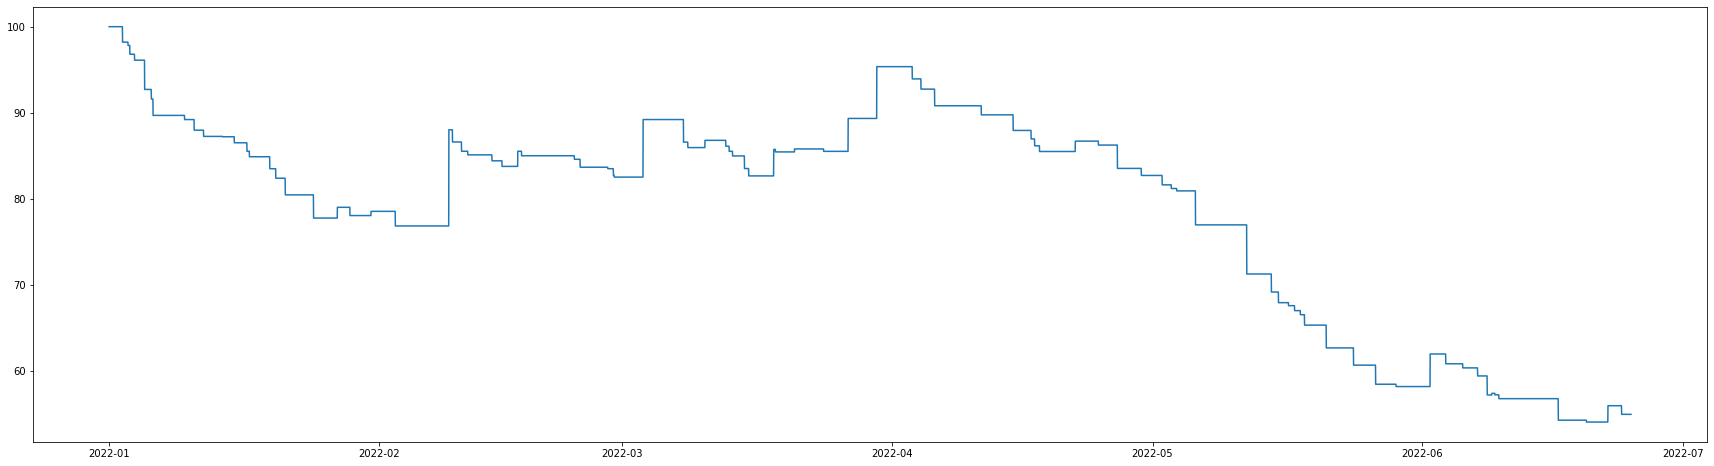

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 8.18%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 15.56%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

BTC-PERP win rate: 15.56%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count       90.000000
mean        -0.633881
std          2.751612
min         -7.414479
25%         -1.702280
50%         -0.816600
75%         -0.412175
max         14.542984


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution BTC-PERP:
       profit_percent
count       90.000000
mean        -0.633881
std          2.751612
min         -7.414479
25%         -1.702280
50%         -0.816600
75%         -0.412175
max         14.542984




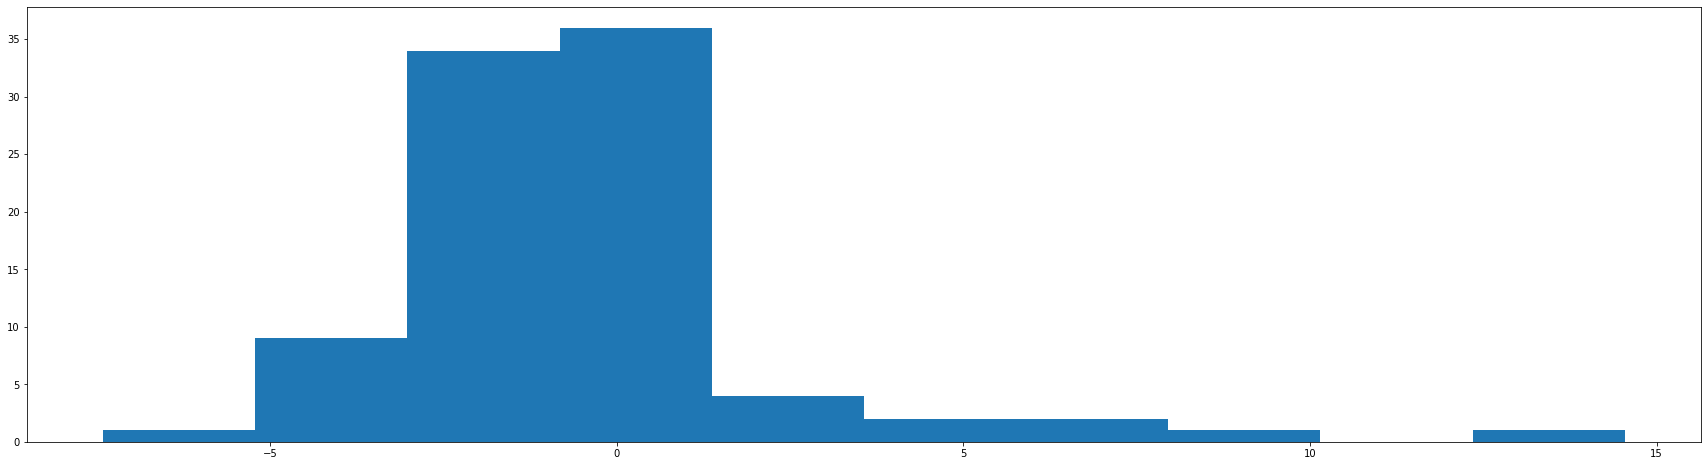

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)